# Equity in Mortality Prediction

How our tools perform across ethnical groups and diverse demographics?


## Load libraries and connect to the database

In [0]:
# Import libraries
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sbs
plt.style.use('ggplot')

# model building
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, auc, confusion_matrix, classification_report
from sklearn.pipeline import Pipeline
from sklearn import preprocessing
from sklearn import metrics
from sklearn import impute

# Make pandas dataframes prettier
from IPython.display import display, HTML

# Access data using Google BigQuery.
from google.colab import auth
from google.cloud import bigquery

In [2]:
from scipy import stats
np.random.seed(1)


import itertools
import os

from keras import layers, regularizers, optimizers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, Conv1D
from keras.layers import AveragePooling2D, MaxPooling2D, MaxPooling1D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.models import Model, load_model
from keras.callbacks import ModelCheckpoint, EarlyStopping


import keras.backend as K
K.set_image_data_format('channels_last')

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

# https://pypi.python.org/pypi/pydot
#!apt-get -qq install -y graphviz && pip install -q pydot
#import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model

Using TensorFlow backend.


In [0]:
# authenticate
auth.authenticate_user()

In [0]:
# Set up environment variables
project_id='hack-aotearoa'
os.environ["GOOGLE_CLOUD_PROJECT"]=project_id

In [0]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',filename=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure()
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
        
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    if filename:
        plt.savefig(filename, dpi=500)
    plt.show()
    
def plot_roc_curve(ground_truth, predictions, filename=None):
    fpr, tpr, thr = roc_curve(y_true=ground_truth, y_score=predictions, drop_intermediate=False)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(15,10))
    lw = 2
    plt.plot(fpr, tpr,
             lw=lw, label='ROC curve (area = %0.4f)' % roc_auc)
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2,
         label='Chance', alpha=.8)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('1 - Specificity')
    plt.ylabel('Sensitivity')
    plt.title('Receiver operating characteristic curve')
    plt.legend(loc="lower right")
    if filename:
        plt.savefig(filename, dpi=500)
    plt.show()
    #return fpr, tpr, thr

def plot_roc_curve_multiple(data, filename=None):
    plt.figure(figsize=(15,10))
    i = 0
    mean_fpr = np.linspace(0, 1, 100)
    tprs = []
    aucs = []
    for k,v in data.items():
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y_true = v[0], y_score = v[1], drop_intermediate=False)
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=4, alpha=0.3,
                 label= f'ROC for {k} (AUC = {roc_auc:.4f})')
        i += 1
    
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('1 - Specificity')
    plt.ylabel('Sensitivity')
    plt.title('Receiver operating characteristic curve')
    plt.legend(loc="lower right")
    if filename:
        plt.savefig(filename, dpi=500)
    plt.show()
    #return mean_fpr, mean_tpr
   

## Load the patient cohort

In [0]:
%%bigquery data

WITH cohort AS
  (
    SELECT
      i.SUBJECT_ID,
      i.HADM_ID,
      i.ICUSTAY_ID,
      i.los,
      DATETIME_DIFF(i.INTIME, p.DOB, YEAR) as AGE,
      --EXTRACT(EPOCH FROM i.INTIME - p.DOB) / 60.0 / 60.0 / 24.0 / 365.242 AS AGE,
      CASE
      WHEN ad.ADMISSION_TYPE = 'ELECTIVE' THEN 1
      ELSE 0 END                                                          AS elective,
      CASE
      WHEN lower(ser.CURR_SERVICE) like '%surg%' then 1
      ELSE 0 END                                                          AS surgical,
      CASE
      WHEN ICD9_CODE BETWEEN '042' AND '0449'
        THEN 1
		  ELSE 0 END                                                          AS AIDS      /* HIV and AIDS */,
      CASE
      WHEN ICD9_CODE BETWEEN '1960' AND '1991' THEN 1
      WHEN ICD9_CODE BETWEEN '20970' AND '20975' THEN 1
      WHEN ICD9_CODE = '20979' THEN 1
      WHEN ICD9_CODE = '78951' THEN 1
      ELSE 0 END                                                         AS METASTATIC_CANCER,
      CASE
      WHEN ICD9_CODE BETWEEN '20000' AND '20238' THEN 1 -- lymphoma
      WHEN ICD9_CODE BETWEEN '20240' AND '20248' THEN 1 -- leukemia
      WHEN ICD9_CODE BETWEEN '20250' AND '20302' THEN 1 -- lymphoma
      WHEN ICD9_CODE BETWEEN '20310' AND '20312' THEN 1 -- leukemia
      WHEN ICD9_CODE BETWEEN '20302' AND '20382' THEN 1 -- lymphoma
      WHEN ICD9_CODE BETWEEN '20400' AND '20522' THEN 1 -- chronic leukemia
      WHEN ICD9_CODE BETWEEN '20580' AND '20702' THEN 1 -- other myeloid leukemia
      WHEN ICD9_CODE BETWEEN '20720' AND '20892' THEN 1 -- other myeloid leukemia
      WHEN ICD9_CODE = '2386 ' THEN 1 -- lymphoma
      WHEN ICD9_CODE = '2733 ' THEN 1 -- lymphoma
      ELSE 0 END                                                         AS LYMPHOMA,
      RANK()
      OVER (
        PARTITION BY i.SUBJECT_ID
        ORDER BY i.INTIME )                                               AS ICUSTAY_ID_order,
      CASE
      WHEN ad.deathtime BETWEEN i.INTIME AND i.OUTTIME
        THEN 1
      ELSE 0 END                                                          AS mort_icu
      --, d.label as variable_name
      ,
      CASE
      WHEN ITEMID IN (723, 223900) AND VALUENUM >= 1 AND VALUENUM <= 5 --OK
        THEN 'GCSVerbal'
      WHEN ITEMID IN (454, 223901) AND VALUENUM >= 1 AND VALUENUM <= 6 --OK
        THEN 'GCSMotor'
      WHEN ITEMID IN (184, 220739) AND VALUENUM >= 1 AND VALUENUM <= 6 --OK
        THEN 'GCSEyes'
      WHEN ITEMID IN (211, 220045) AND VALUENUM > 0 AND VALUENUM < 300 --OK
        THEN 'HEART RATE'
      WHEN ITEMID IN (51, 442, 455, 6701, 220179, 220050) AND VALUENUM > 0 AND VALUENUM < 400 --OK
        THEN 'SYSTOLIC BP'
      WHEN ITEMID IN (8368, 8440, 8441, 8555, 220180, 220051) AND VALUENUM > 0 AND VALUENUM < 300 --OK
        THEN 'DIASTOLIC BP'
      WHEN ITEMID IN (223761, 678) AND VALUENUM > 70 AND VALUENUM < 120 --OK
        THEN 'TEMPERATURE' -- converted to degC in VALUENUM call
      WHEN ITEMID IN (223762, 676) AND VALUENUM > 10 AND VALUENUM < 50 --OK
        THEN 'TEMPERATURE'
      WHEN ITEMID IN (223835, 3420, 3422, 190) --AND VALUENUM > 0 AND VALUENUM < 100 --OK
        THEN 'FiO2'
      ELSE NULL END                                                       AS measurement_name,
      case
          when ITEMID = 223835
            then case
              when VALUENUM > 0 and VALUENUM <= 1
                then VALUENUM * 100
              -- improperly input data - looks like O2 flow in litres
              when VALUENUM > 1 and VALUENUM < 21
                then null
              when VALUENUM >= 21 and VALUENUM <= 100
                then VALUENUM
              else null end -- unphysiological
        when ITEMID in (3420, 3422)
        -- all these VALUEs are well formatted
            then VALUENUM
        when ITEMID = 190 and VALUENUM > 0.20 and VALUENUM < 1
        -- well formatted but not in %
            then VALUENUM * 100
        WHEN ITEMID IN (223761, 678)
          then (c.VALUENUM -32)/1.8 --convert F to C
      else VALUENUM end                                                          AS VALUE,
      DATETIME_DIFF(c.CHARTTIME, i.INTIME, HOUR)    AS icu_time_hr
    FROM `physionet-data.mimiciii_clinical.icustays` i
      JOIN `physionet-data.mimiciii_clinical.patients` p ON i.SUBJECT_ID = p.SUBJECT_ID
      JOIN `physionet-data.mimiciii_clinical.admissions` ad ON ad.HADM_ID = i.HADM_ID AND ad.SUBJECT_ID = i.SUBJECT_ID
      JOIN `physionet-data.mimiciii_clinical.diagnoses_icd` icd on ad.HADM_ID = icd.HADM_ID AND ad.SUBJECT_ID = icd.SUBJECT_ID
      JOIN `physionet-data.mimiciii_clinical.services` ser on ad.HADM_ID = ser.HADM_ID AND ad.SUBJECT_ID = ser.SUBJECT_ID
      LEFT JOIN `physionet-data.mimiciii_clinical.chartevents` c
        ON i.ICUSTAY_ID = c.ICUSTAY_ID
           AND c.ERROR != 1
           AND c.CHARTTIME BETWEEN (i.INTIME) AND DATETIME_ADD(i.INTIME, INTERVAL 2 DAY)
    WHERE i.los >= 2)
  SELECT *
  FROM cohort
  WHERE icustay_id_order = 1 AND age > 16 
  AND VALUE IS NOT NULL
  AND MEASUREMENT_NAME IS NOT NULL
  ORDER BY subject_id, icu_time_hr
  LIMIT 10000000

In [238]:
data.head()

,SUBJECT_ID,HADM_ID,ICUSTAY_ID,los,AGE,elective,surgical,AIDS,METASTATIC_CANCER,LYMPHOMA,ICUSTAY_ID_order,mort_icu,measurement_name,VALUE,icu_time_hr
0,188,123860,213646,3.1676,55,0,0,0,0,0,1,0,GCSEyes,1.0,1
1,188,123860,213646,3.1676,55,0,0,0,0,0,1,0,DIASTOLIC BP,91.0,1
2,188,123860,213646,3.1676,55,0,0,0,0,0,1,0,DIASTOLIC BP,91.0,1
3,188,123860,213646,3.1676,55,0,0,0,0,0,1,0,GCSVerbal,1.0,1
4,188,123860,213646,3.1676,55,0,0,0,0,0,1,0,GCSVerbal,1.0,1


In [239]:
data = data[data.icu_time_hr != 48]
print("Number of rows: {0}".format(data.shape[0]))
#sorted_data = data.sort_values(by=['subject_id', 'measurement_name'])
mortality_labels = data.drop_duplicates(subset=['SUBJECT_ID'])[['SUBJECT_ID','mort_icu']]
print("Number of distinct IDs: {0}".format(mortality_labels.shape[0]))
inputs = data.pivot_table(index=['SUBJECT_ID', 'measurement_name'], 
                              columns='icu_time_hr', values='VALUE', aggfunc=np.mean)
print("Number of distinct IDs after pivoting: {0}".format(inputs.index.levels[0].shape[0]))

index_names = inputs.index.names
new_index = pd.MultiIndex.from_product(inputs.index.levels)
new_index.names = index_names
inputs = inputs.reindex(new_index).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1)
print("Number of distinct series after re-indexing: {0}".format(inputs.index.levels[1].shape[0]))
print("Number of distinct hours after re-indexing: {0}".format(inputs.shape[1]))

Number of rows: 9837994
Number of distinct IDs: 1627
Number of distinct IDs after pivoting: 1627
Number of distinct series after re-indexing: 8
Number of distinct hours after re-indexing: 48


In [240]:
data['measurement_name'] = 'AGE'
ages = data.pivot_table(index=['SUBJECT_ID', 'measurement_name'], 
                                  columns='icu_time_hr', values='AGE', aggfunc=np.mean)\
                                  .fillna(axis=1, method='bfill').fillna(axis=1, method='ffill')
inputs = pd.concat([inputs, ages]).sort_index()
inputs

icu_time_hr                          0           1   ...          46          47
SUBJECT_ID measurement_name                          ...                        
188        AGE                55.000000   55.000000  ...   55.000000   55.000000
           DIASTOLIC BP       91.000000   91.000000  ...   79.000000   76.000000
           FiO2               40.000000   40.000000  ...   35.000000   35.000000
           GCSEyes             1.000000    1.000000  ...    4.000000    4.000000
           GCSMotor            1.000000    1.000000  ...    6.000000    6.000000
...                                 ...         ...  ...         ...         ...
48174      GCSMotor            4.000000    4.000000  ...    6.000000    6.000000
           GCSVerbal           1.000000    1.000000  ...    4.000000    4.000000
           HEART RATE        109.000000  108.000000  ...  113.000000  113.000000
           SYSTOLIC BP       115.000000  115.000000  ...  144.000000  144.000000
           TEMPERATURE        38.277778   38.277778  ...   36.944444   36.944444

[14643 rows x 48 columns]

In [241]:
len(index_names)

2

In [0]:
def model_func(input_shape):
  X_input = Input(input_shape, name='input')
    
  #First layer
  
  #Conv
  short_term_conv = Conv2D(16, (3,1), strides = (1,1), padding = 'same', name = '3h_conv')(X_input)
  medium_term_conv = Conv2D(16, (6,1), strides = (1,1), padding = 'same',
                            name = '6h_conv')(X_input)
  long_term_conv = Conv2D(16, (12,1), strides = (1,1), padding = 'same',
                          name = '12h_conv')(X_input)
  #extra_long_term_conv = Conv2D(64, (24,1), strides = (1,1), padding = 'same',
  #                              name = '24h_conv')(X_input)
  #ReLU
  short_term_conv = Activation('relu')(short_term_conv)
  medium_term_conv = Activation('relu')(medium_term_conv)
  long_term_conv = Activation('relu')(long_term_conv)
  #extra_long_term_conv = Activation('relu')(extra_long_term_conv)
  #
  #Max pooling
  short_term_conv = AveragePooling2D(pool_size = (1,3), padding = 'same', 
                                    name = '3h_pooled')(short_term_conv)
  medium_term_conv = AveragePooling2D(pool_size = (1,3), padding = 'same', 
                                    name = '6h_pooled')(medium_term_conv)
  long_term_conv = AveragePooling2D(pool_size = (1,3), padding = 'same', 
                                  name = '12h_pooled')(long_term_conv)
  #extra_long_term_conv = MaxPooling2D(pool_size = (1,3), padding = 'same',
  #                                    name = '24h_pooled')(extra_long_term_conv)
  #Concat
  X = layers.concatenate([short_term_conv, medium_term_conv, long_term_conv], axis=3)
  #Dropout
  if use_dropout:
      X = Dropout(conv_drop_prob, name = 'dropout1')(X)
  #BatchNorm
  X = BatchNormalization(axis = 3, name = 'bn1')(X)
  
  
  #Fully connected layer
  X = Flatten()(X)
  X = Dense(256, activation = 'relu', name = 'fc1', kernel_regularizer=regularizers.l2(l2_penalty))(X)
  #Dropout
  if use_dropout:
      X = Dropout(fc_drop_prob, name = 'dropout3')(X)
  #BatchNorm
  X = BatchNormalization(axis = 1, name='bn3')(X)
  
  
  #Output softmax layer
  X = Dense(1, activation = 'sigmoid', name = 'fc2', kernel_regularizer=regularizers.l2(l2_penalty))(X)
  
  model = Model(inputs = X_input, outputs = X, name='icu_mortality_conv')
  return model

In [243]:
from sklearn.model_selection import StratifiedKFold
cv = StratifiedKFold(n_splits=4, random_state=42)
cv_idx = list(cv.split(X=np.zeros(mortality_labels.shape[0]), y=mortality_labels['mort_icu'].values))
train, validation = list(cv_idx)[0]

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


In [0]:
#mean = inputs.loc[train].mean(level='measurement_name').mean(axis=1)
#std = inputs.loc[train].std(level='measurement_name').mean(axis=1)
#Store training fold mean and std to standardize validation folds later
#Extra dimension is added to make broadcasted division and subtraction possible
#mean = mean.values[:, None]
#std = std.values[:, None]

In [245]:
X = inputs.values.reshape([inputs.index.levels[0].shape[0], inputs.index.levels[1].shape[0], inputs.shape[1]])
y = mortality_labels.values

#Reshape so each physiological time series 
#becomes a channel (3D) instead of a matrix row (2D)
X = X.reshape((-1, 1, inputs.index.levels[1].shape[0], inputs.shape[1])).astype(np.float32)
y = y[:, 1]
y = y[:, None].astype(np.float32)
print("Training inputs shape: {0}".format(X.shape))
print("Training labels shape: {0}".format(y.shape))

Training inputs shape: (1627, 1, 9, 48)
Training labels shape: (1627, 1)


In [246]:
mean = X[train].mean(axis=0)
std = X[train].std(axis=0)
mean = mean[:, None]
std = std[:, None]
mean.shape

(1, 1, 9, 48)

In [247]:
print(X[train].shape)
print(mean.shape)
((X[train]-mean)).shape

(1220, 1, 9, 48)
(1, 1, 9, 48)


(1220, 1, 9, 48)

In [248]:
batch_size = 32
epochs = 50
class_weight = {0:1, 1:10} 
use_dropout = True
conv_drop_prob = 0.45
fc_drop_prob = 0.45
l2_penalty = 0.0

model = model_func((1,inputs.index.levels[1].shape[0],48))
sgd = optimizers.SGD(lr=0.01, decay=1e-7, momentum=0.9, nesterov=True)
model.compile(optimizer = sgd, loss = 'binary_crossentropy', metrics = ['accuracy'])

scaled_X_train = (X[train] - mean)/std #Standardize
scaled_X_train = np.nan_to_num(scaled_X_train) #Implicit mean imputation for remaining NaNs
scaled_X_validation = (X[validation] - mean)/std #Standardize using train set mean. No Leaking
scaled_X_validation = np.nan_to_num(scaled_X_validation) #Implicit mean imputation for remaining NaNs


model.fit(x = scaled_X_train, y = y[train], 
                              epochs = epochs, batch_size = batch_size, 
                              class_weight=class_weight, validation_data=(scaled_X_validation, 
                                                                          y[validation]))

predictions_training_set = model.predict(scaled_X_train)
predictions = model.predict(scaled_X_validation)

Train on 1220 samples, validate on 407 samples
Epoch 1/50
1220/1220 [==============================] - 2s 1ms/step - loss: 1.8762 - acc: 0.5139 - val_loss: 2.4247 - val_acc: 0.2432
Epoch 2/50
1220/1220 [==============================] - 0s 235us/step - loss: 2.0783 - acc: 0.5057 - val_loss: 1.8544 - val_acc: 0.2531
Epoch 3/50
1220/1220 [==============================] - 0s 233us/step - loss: 2.2947 - acc: 0.5000 - val_loss: 1.0670 - val_acc: 0.5184
Epoch 4/50
1220/1220 [==============================] - 0s 254us/step - loss: 2.2328 - acc: 0.4770 - val_loss: 0.6066 - val_acc: 0.6634
Epoch 5/50
1220/1220 [==============================] - 0s 252us/step - loss: 2.2058 - acc: 0.5033 - val_loss: 1.3217 - val_acc: 0.5111
Epoch 6/50
1220/1220 [==============================] - 0s 255us/step - loss: 1.9025 - acc: 0.5385 - val_loss: 0.6717 - val_acc: 0.6757
Epoch 7/50
1220/1220 [==============================] - 0s 268us/step - loss: 1.7677 - acc: 0.5500 - val_loss: 1.0406 - val_acc: 0.6364
Epo

In [0]:
params = {'patients': list(mortality_labels.iloc[validation]['SUBJECT_ID'].values)}

In [0]:
%%bigquery demographics --params $params

SELECT DISTINCT (p.SUBJECT_ID), ad.RELIGION, ad.ETHNICITY, ad.MARITAL_STATUS, ad.INSURANCE, p.gender

FROM `physionet-data.mimiciii_clinical.admissions` ad
JOIN `physionet-data.mimiciii_clinical.patients` p on ad.SUBJECT_ID = p.SUBJECT_ID

WHERE p.SUBJECT_ID in UNNEST(@patients)

In [252]:
demographics = demographics.drop_duplicates(subset='SUBJECT_ID')
demographics.head()

,SUBJECT_ID,RELIGION,ETHNICITY,MARITAL_STATUS,INSURANCE,gender
0,698,JEWISH,WHITE,SINGLE,Medicare,F
1,1186,JEWISH,WHITE,SINGLE,Medicare,M
2,1872,NOT SPECIFIED,WHITE,SEPARATED,Medicare,F
3,2298,PROTESTANT QUAKER,BLACK/AFRICAN AMERICAN,DIVORCED,Medicare,F
4,3070,CATHOLIC,WHITE,SINGLE,Medicare,M


In [253]:
predictions_df = pd.DataFrame(data={'predictions':predictions[:,0], 
                                    'mort_icu': mortality_labels.iloc[validation]['mort_icu'].values,
                                    'SUBJECT_ID':mortality_labels.iloc[validation]['SUBJECT_ID'].values})
predictions_df

,predictions,mort_icu,SUBJECT_ID
0,0.291927,0,188
1,0.266352,0,199
2,0.320867,0,422
3,0.170765,1,502
4,0.325246,0,533
...,...,...,...
402,0.163291,0,30714
403,0.432751,0,30829
404,0.480180,0,30887
405,0.134890,0,30915


In [254]:
mimiciii = demographics.merge(predictions_df, on='SUBJECT_ID')
mimiciii.head()

,SUBJECT_ID,RELIGION,ETHNICITY,MARITAL_STATUS,INSURANCE,gender,predictions,mort_icu
0,698,JEWISH,WHITE,SINGLE,Medicare,F,0.066170,0
1,1186,JEWISH,WHITE,SINGLE,Medicare,M,0.329878,0
2,1872,NOT SPECIFIED,WHITE,SEPARATED,Medicare,F,0.087807,0
3,2298,PROTESTANT QUAKER,BLACK/AFRICAN AMERICAN,DIVORCED,Medicare,F,0.441149,0
4,3070,CATHOLIC,WHITE,SINGLE,Medicare,M,0.259276,0


In [255]:
### Function for converting the ethnicity data into coarser categories
def ethnicCoding(dfIN, inColName, outColName):
  
  # fill in missing data to 'other'
  dfIN[inColName][dfIN[inColName].isnull()] = "other"
  # conver to lower
  dfIN[inColName] = dfIN[inColName].str.lower()

  #1	WHITE
  #12	WHITE - EASTERN EUROPEAN
  #14	WHITE - RUSSIAN
  #24	WHITE - OTHER EUROPEAN
  whiteMask = pd.Series(dfIN[inColName]).str.contains('white').tolist()
  dfIN.loc[whiteMask, outColName] = 'white'

  #2	BLACK/AFRICAN AMERICAN
  #13	BLACK/CAPE VERDEAN
  #15	BLACK/HAITIAN
  #16	CARIBBEAN ISLAND
  #18	BLACK/AFRICAN
  blackMask = pd.Series(dfIN[inColName]).str.contains('black|caribbean').tolist()
  dfIN.loc[blackMask, outColName] = 'black'

  #3	HISPANIC/LATINO - PUERTO RICAN
  #6	HISPANIC OR LATINO
  #21	HISPANIC/LATINO - DOMINICAN
  #22	HISPANIC/LATINO - CUBAN
  #23	HISPANIC/LATINO - GUATEMALAN
  #26	PORTUGUESE
  #28	SOUTH AMERICAN
  #30	HISPANIC/LATINO - CENTRAL AMERICAN (OTHER)
  #33	HISPANIC/LATINO - SALVADORAN
  #35	WHITE - BRAZILIAN
  #36	HISPANIC/LATINO - COLOMBIAN
  #38	HISPANIC/LATINO - MEXICAN
  #41	HISPANIC/LATINO - HONDURAN
  hispMask = pd.Series(dfIN[inColName]).str.contains('hispanic|portuguese|south american|brazilian').tolist()
  dfIN.loc[hispMask, outColName] = 'hispanic'

  #4	OTHER
  #7	UNKNOWN/NOT SPECIFIED
  #8	PATIENT DECLINED TO ANSWER
  #11	MULTI RACE ETHNICITY
  #17	UNABLE TO OBTAIN
  unknownMask = pd.Series(dfIN[inColName]).str.contains('other|unknown|declined|multi|unable').tolist()
  dfIN.loc[unknownMask, outColName] = 'other'  

  #5	ASIAN
  #9	ASIAN - CHINESE
  #19	ASIAN - OTHER
  #20	ASIAN - FILIPINO
  #25	ASIAN - KOREAN
  #27	ASIAN - CAMBODIAN
  #29	ASIAN - ASIAN INDIAN
  #31	ASIAN - VIETNAMESE
  #37	ASIAN - THAI
  #40	ASIAN - JAPANESE
  asianMask = pd.Series(dfIN[inColName]).str.contains('asian').tolist()
  dfIN.loc[asianMask, outColName] = 'asian'  
  
  #10 AMERICAN INDIAN/ALASKA NATIVE
  #39	AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE
  americanindianMask = pd.Series(dfIN[inColName]).str.contains('american indian').tolist()
  dfIN.loc[americanindianMask, outColName] = 'americanindian'  
  
  #32	MIDDLE EASTERN
  middleeasternMask = pd.Series(dfIN[inColName]).str.contains('middle').tolist()
  dfIN.loc[middleeasternMask, outColName] = 'middle'  
  
  #34	NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER
  pacificMask = pd.Series(dfIN[inColName]).str.contains('pacific').tolist()
  dfIN.loc[pacificMask, outColName] = 'pacific'  
  
  return(dfIN)
  
### Function for converting the religion data into coarser categories
def religionCoding(dfIN, inColName, outColName):
  
  # fill in missing data to 'other'
  dfIN[inColName][dfIN[inColName].isnull()] = "other"
  # conver to lower
  dfIN[inColName] = dfIN[inColName].str.lower()

#1	EPISCOPALIAN
#5	CATHOLIC
#7	PROTESTANT QUAKER
#8	GREEK ORTHODOX
#9	JEHOVAH'S WITNESS
#10	UNITARIAN-UNIVERSALIST
#12	7TH DAY ADVENTIST
#13	BAPTIST
#16	METHODIST
#18	CHRISTIAN SCIENTIST
#19	ROMANIAN EAST. ORTH
#21	LUTHERAN
  christianMask = pd.Series(dfIN[inColName]).str.contains('episc|catho|prote|greek|jehov|unit|adven|bapt|meth|scien|roman|luth').tolist()
  dfIN.loc[christianMask, outColName] = 'christian'
  
#2	OTHER
#4	NOT SPECIFIED
#6	UNOBTAINABLE
#11	null
  otherMask = pd.Series(dfIN[inColName]).str.contains('other|specif|unob|null').tolist()
  dfIN.loc[otherMask, outColName] = 'other' 

#3	JEWISH
#17	HEBREW
  jewMask = pd.Series(dfIN[inColName]).str.contains('jew|hebr').tolist()
  dfIN.loc[jewMask, outColName] = 'jewish' 

#14	BUDDHIST
  budMask = pd.Series(dfIN[inColName]).str.contains('buddhist').tolist()
  dfIN.loc[budMask, outColName] = 'buddhist' 

#15	MUSLIM
  muslimMask = pd.Series(dfIN[inColName]).str.contains('muslim').tolist()
  dfIN.loc[muslimMask, outColName] = 'muslim' 

#20	HINDU
  hinduMask = pd.Series(dfIN[inColName]).str.contains('hindu').tolist()
  dfIN.loc[hinduMask, outColName] = 'hindu' 
  
  return(dfIN)
  
  
def doConversions(dfIN):
  dfIN = ethnicCoding(dfIN, 'ETHNICITY', "EthCat")
  dfIN = religionCoding(dfIN, "RELIGION", "RelCat")
  return(dfIN)

mimiciii = doConversions(mimiciii)
mimiciii.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,SUBJECT_ID,RELIGION,ETHNICITY,MARITAL_STATUS,INSURANCE,gender,predictions,mort_icu,EthCat,RelCat
0,698,jewish,white,SINGLE,Medicare,F,0.066170,0,white,jewish
1,1186,jewish,white,SINGLE,Medicare,M,0.329878,0,white,jewish
2,1872,not specified,white,SEPARATED,Medicare,F,0.087807,0,white,other
3,2298,protestant quaker,black/african american,DIVORCED,Medicare,F,0.441149,0,black,christian
4,3070,catholic,white,SINGLE,Medicare,M,0.259276,0,white,christian


In [256]:
mimiciii['predicted_mort_icu'] = mimiciii['predictions'] > 0.5
mimiciii['predicted_mort_icu'] = mimiciii['predicted_mort_icu'].astype(int)
mimiciii.head()

,SUBJECT_ID,RELIGION,ETHNICITY,MARITAL_STATUS,INSURANCE,gender,predictions,mort_icu,EthCat,RelCat,predicted_mort_icu
0,698,jewish,white,SINGLE,Medicare,F,0.066170,0,white,jewish,0
1,1186,jewish,white,SINGLE,Medicare,M,0.329878,0,white,jewish,0
2,1872,not specified,white,SEPARATED,Medicare,F,0.087807,0,white,other,0
3,2298,protestant quaker,black/african american,DIVORCED,Medicare,F,0.441149,0,black,christian,0
4,3070,catholic,white,SINGLE,Medicare,M,0.259276,0,white,christian,0


## Overall Performance

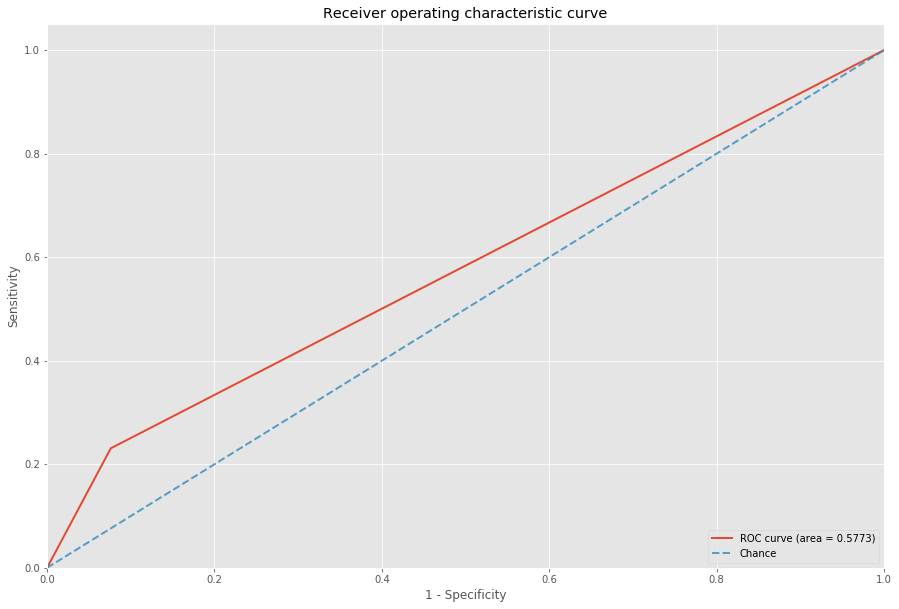

In [265]:
observed_mortality = mimiciii[['mort_icu']].values
predicted_mortality = mimiciii[['predicted_mort_icu']].values
plot_roc_curve(observed_mortality, predicted_mortality, filename='ROC_overall_DL')

## Performance by Gender

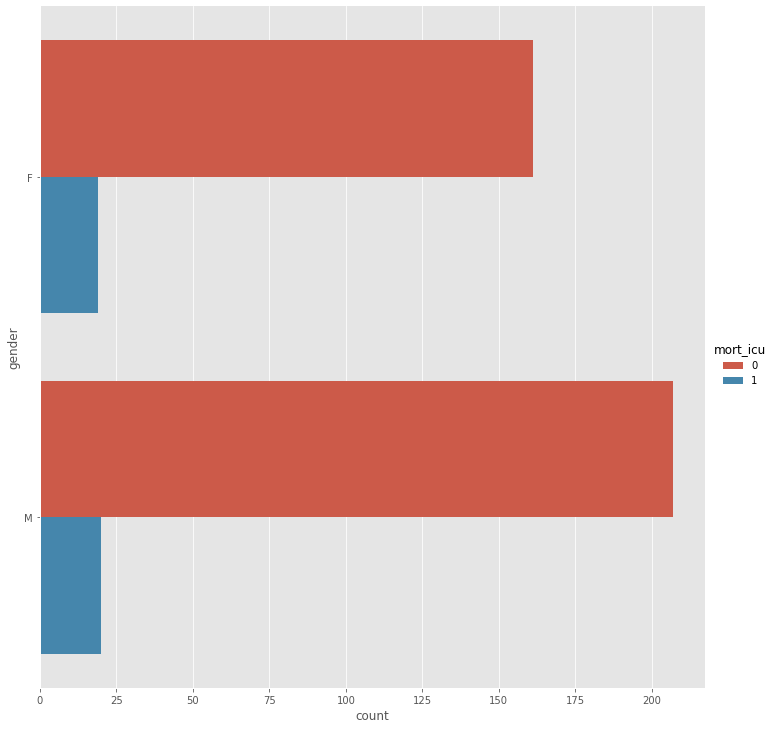

In [258]:
sbs.catplot(y='gender', hue='mort_icu', kind='count', data=mimiciii, height=10, aspect=1)

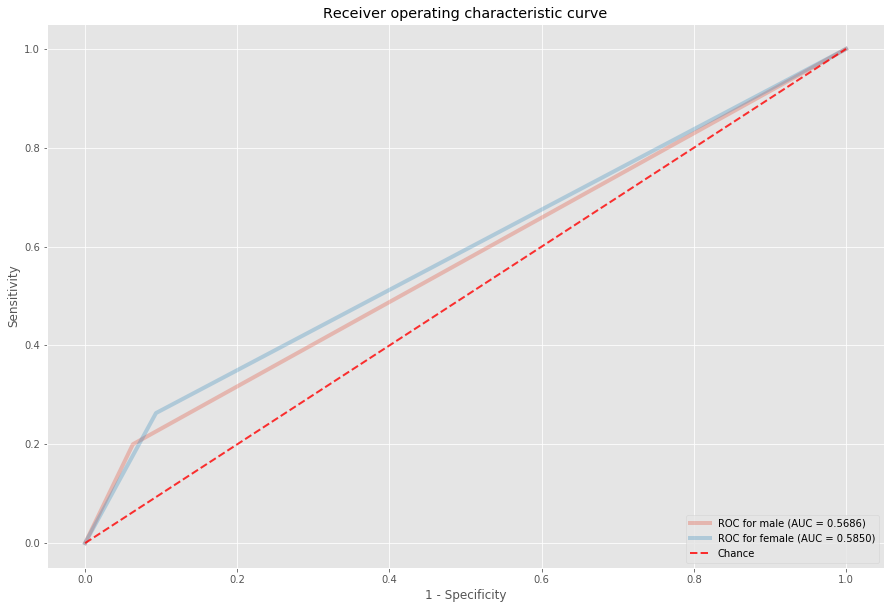

In [266]:
data = dict()
data['male'] = [mimiciii[mimiciii.gender == 'M'][['mort_icu']].values,
                mimiciii[mimiciii.gender == 'M'][['predicted_mort_icu']].values]
data['female'] = [mimiciii[mimiciii.gender == 'F'][['mort_icu']].values,
                  mimiciii[mimiciii.gender == 'F'][['predicted_mort_icu']].values]
plot_roc_curve_multiple(data, filename='ROC_gender_DL')
#print(data.items())

## Performance by Ethnicity

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


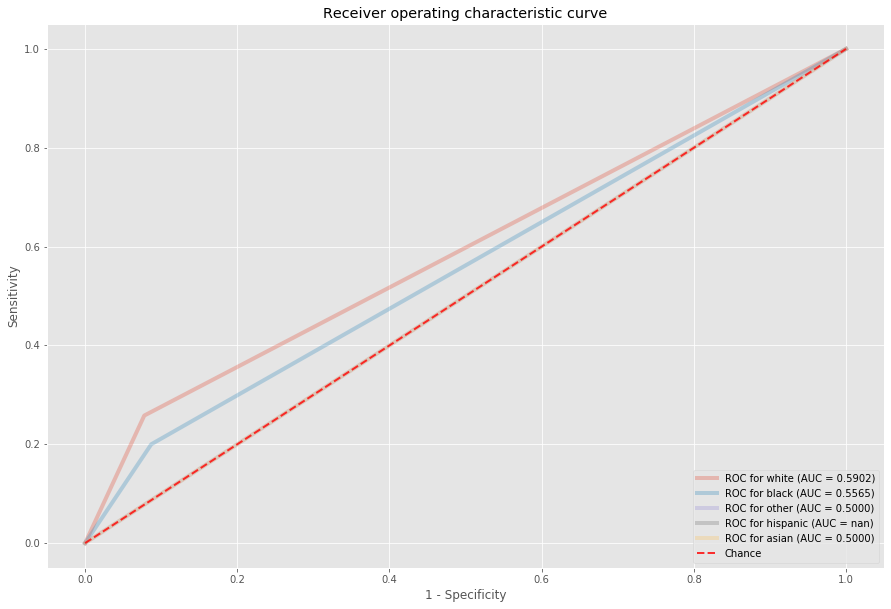

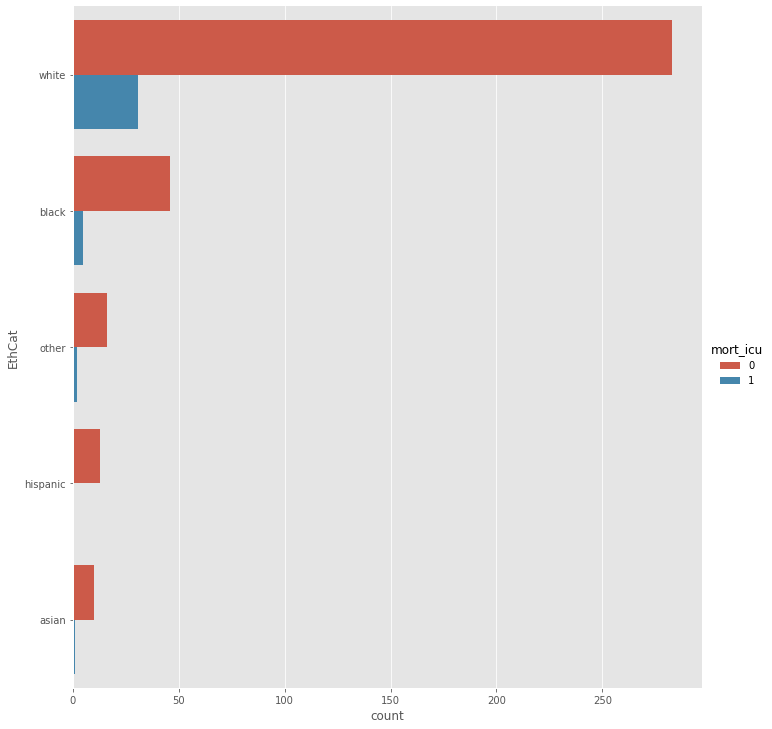

In [267]:
data = dict()
for e in mimiciii.EthCat.unique():
  data[e] = [mimiciii[mimiciii.EthCat == e][['mort_icu']].values,
                mimiciii[mimiciii.EthCat == e][['predicted_mort_icu']].values]

plot_roc_curve_multiple(data, filename='ROC_ethnicity_DL')
sbs.catplot(y='EthCat', hue='mort_icu', kind='count', data=mimiciii, height=10, aspect=1)

## Performance by Marital Status

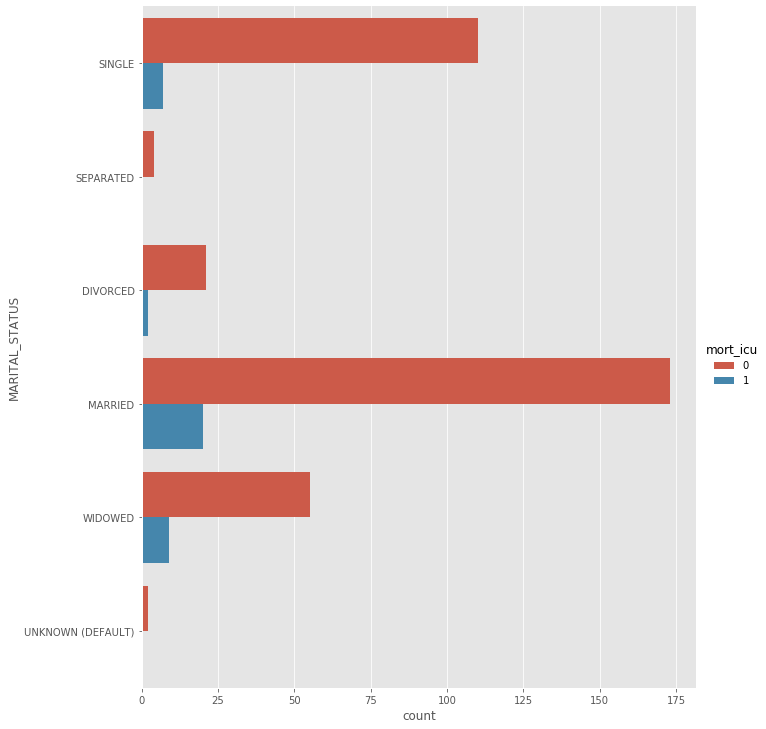

In [261]:
sbs.catplot(y='MARITAL_STATUS', hue='mort_icu', kind='count', data=mimiciii, height=10, aspect=1)

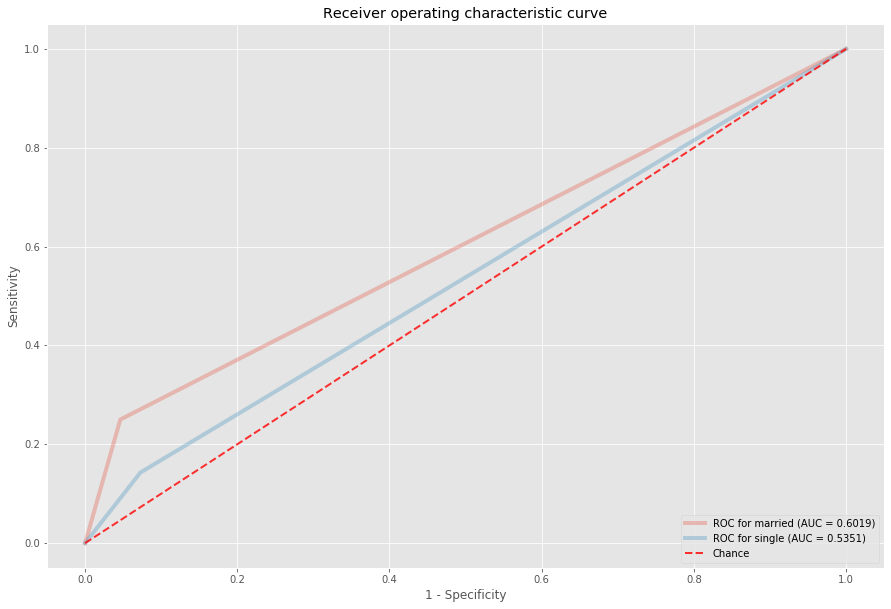

In [268]:
data = dict()
data['married'] = [mimiciii[mimiciii.MARITAL_STATUS == 'MARRIED'][['mort_icu']].values,
                   mimiciii[mimiciii.MARITAL_STATUS == 'MARRIED'][['predicted_mort_icu']].values]
data['single'] = [mimiciii[mimiciii.MARITAL_STATUS == 'SINGLE'][['mort_icu']].values,
                  mimiciii[mimiciii.MARITAL_STATUS == 'SINGLE'][['predicted_mort_icu']].values]

plot_roc_curve_multiple(data, filename='ROC_marital_DL')

## Performance by Insurance Status

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


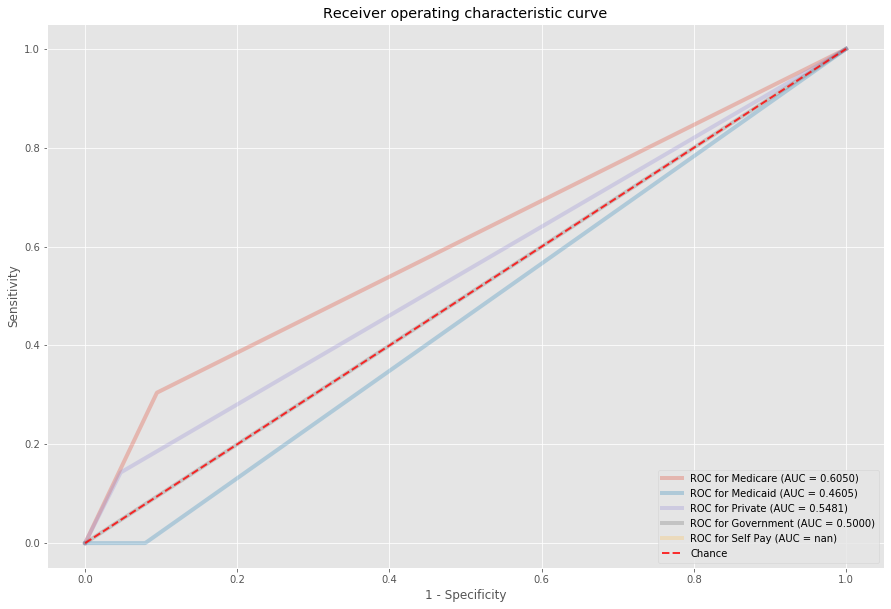

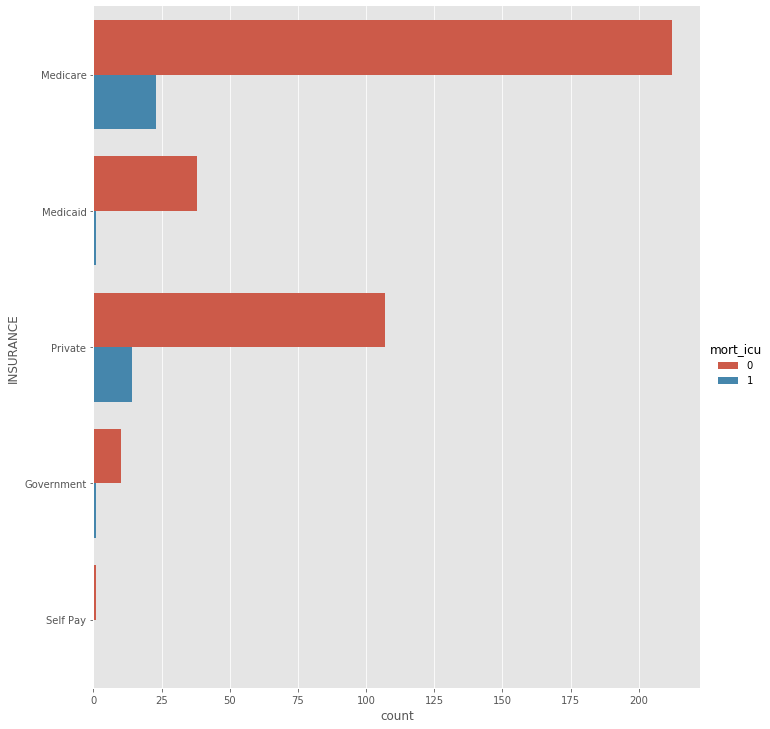

In [269]:
data = dict()
for e in mimiciii.INSURANCE.unique():
  data[e] = [mimiciii[mimiciii.INSURANCE == e][['mort_icu']].values,
                mimiciii[mimiciii.INSURANCE == e][['predicted_mort_icu']].values]

plot_roc_curve_multiple(data, filename='ROC_insurance_DL')
sbs.catplot(y='INSURANCE', hue='mort_icu', kind='count', data=mimiciii, height=10, aspect=1)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


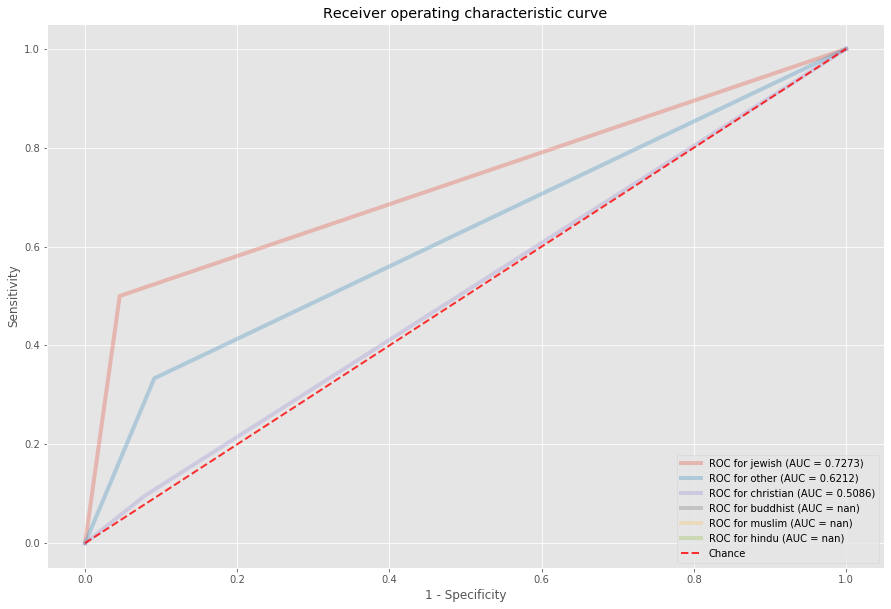

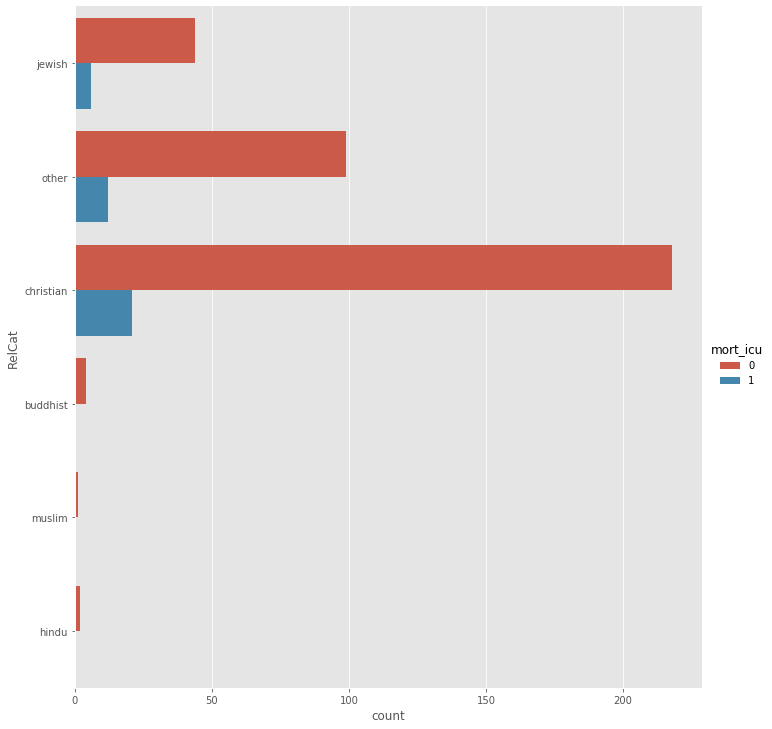

In [270]:
mimiciii.RelCat.unique()
data = dict()
for e in mimiciii.RelCat.unique():
  data[e] = [mimiciii[mimiciii.RelCat == e][['mort_icu']].values,
                mimiciii[mimiciii.RelCat == e][['predicted_mort_icu']].values]

plot_roc_curve_multiple(data, filename='ROC_religion_DL')
sbs.catplot(y='RelCat', hue='mort_icu', kind='count', data=mimiciii, height=10, aspect=1)

In [0]:
!apt-get -qq install -y graphviz && pip install -q pydot
import pydot

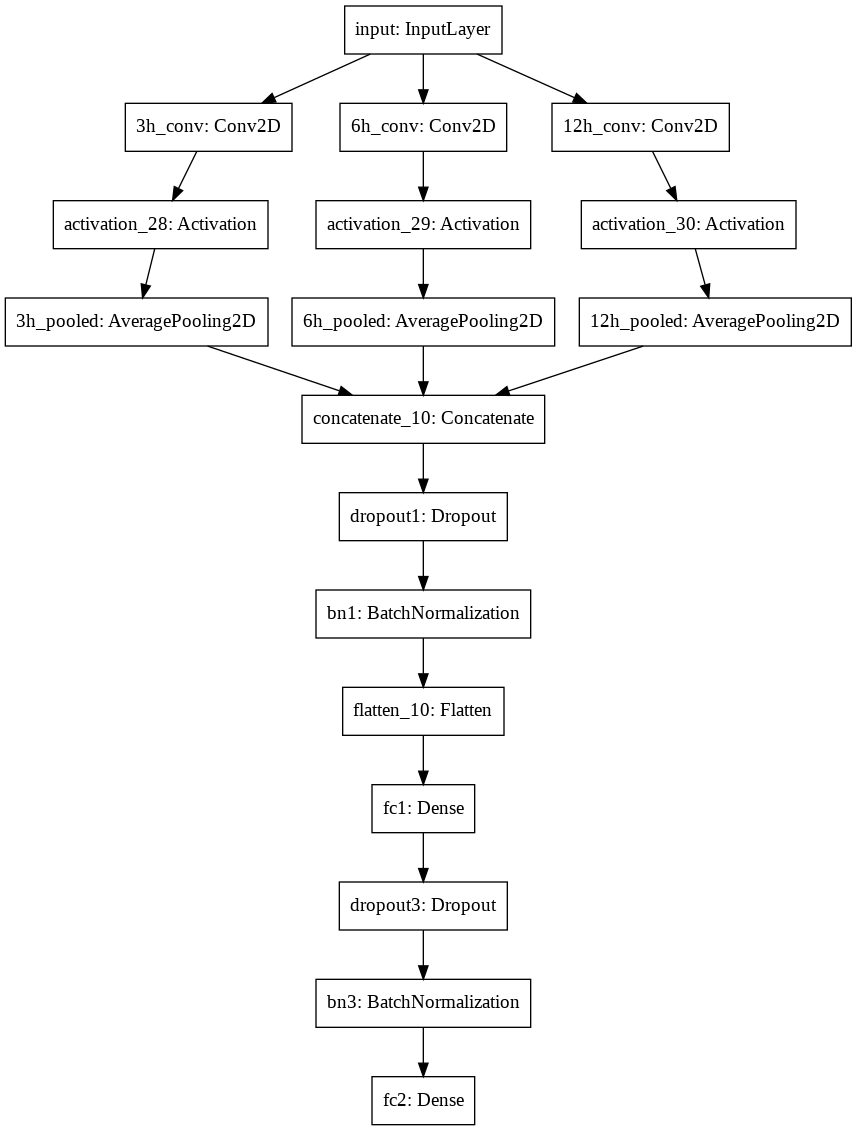

In [272]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
plot_model(model, to_file='model.png')